# Import 

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt


# 데이터 불러오기 & 전처리

In [2]:
# 데이터 불러오기
cancer = load_breast_cancer() # 유방암 데이터 불러오기
x = cancer.data # 입력 값 
y = cancer.target # 출력 값

In [3]:
#전체 데이터를 훈련 데이터랑 최후의 테스트 데이터로 나눔 
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify = y, test_size = 0.2, random_state = 42)

# 훈련 데이터를 훈련 데이터랑 검증 데이터로 나눔 
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify = y_train_all, test_size = 0.2, random_state = 42)

In [4]:
# 훈련 세트와 검증 세트의 크기 확인
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [6]:
scaler = StandardScaler()
scaler.fit(x_train)
# scaler로 평균이 0, 표준 편차가 1인 데이터셋으로 변환
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

# 모델 클래스

In [7]:
# 단일 레이어
class SingleLayer:
    def __init__(self, learning_rate = 0.1, l1=0, l2=0):
        self.w = None # 가중치
        self.b = None # 절편
        self.losses = [] # 훈련 데이터에 대한 손실
        self.val_losses = [] # 검증 데이터에 대한 손실
        self.w_history = [] # 가중치 기록
        self.lr = learning_rate # 학습률(내가 따로 지정하는거)
        self.l1 = l1 # L1손실 하이퍼 파라미터
        self.l2 = l2 # L2손실 하이퍼 파라미터

    def forpass(self,x): # 정방향 계산
        z = np.dot(x, self.w) + self.b # 예측값 계산(입력 데이터 * 가중치 + 절편)
        return z

    def backprop(self, x, err): # 역방향 계산
        m = len(x) # 그래디언트 크기. len() : 넘파이 배열의 행 크기 반환.
        w_grad = np.dot(x.T, err) / m # 가중치에 대한 평균 그래디언트
        b_grad = np.sum(err)/m # 절편에 대한 평균 그래디언트
        return w_grad, b_grad
    
    def activation(self, z): # 예측값을 0~1 사이의 값으로 만들어버림.
        a = 1/ (1+ np.exp(-z)) # 시그모이드 계산
        return a

    def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
        # 행렬 연산을 위해 변환
        y = y.reshape(-1,1) # 열 벡터로 바꿈([ㅁ ㅁ ㅁ ㅁ]^T)
        y_val = y_val.reshape(-1,1) # 열 벡터로 바꿈
        m = len(x)
        #가중치, 절편 초기값 설정
        self.w = np.ones((x.shape[1],1)) # 가중치 초기화([1,1,1]^T)
        self.b = 0
        self.w_history.append(self.w.copy()) # 가중치 기록

        # 에포크만큼 반복
        for i in range(epochs):
            z = self.forpass(x) # 예측값 
            a = self.activation(z) # 활성화 함수
            err = -(y-a) #실제 값 - 예측값 = 오차
            #오차를 역전파하여 그래디언트 계산
            w_grad, b_grad = self.backprop(x, err)
            #그래디언트에서 페널티 항의 미분값을 더함
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m # L1규제, L2규제를 적용해 그래디언트 계산
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            #가중치 기록
            self.w_history.append(self.w.copy())
            # 클리핑(역전파 과정에서 그래디언트가 비정상적으로 작아지거나 커지는거 방지)
            a = np.clip(a, 1e-10, 1-1e-10)
            # 로그 손실과 규제 손실을 더하여 리스트에 추가
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss+self.reg_loss())/m) # 평균 손실
            # 검증 세트에 대한 손실 계산
            self.update_val_loss(x_val, y_val)

    def predict(self,x):
        z = self.forpass(x)
        return z>0
    
    def score(self, x, y):
        # 예측값, 타깃 값 비교해 True의 비율 반환
        return np.mean(self.predict(x) == y.reshape(-1,1))
    
    def reg_loss(self):
        # 가중치에 규제 적용
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)

    # 검증 세트에 대한 손실 계산
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val) # 정방향 계산
        a = self.activation(z) # 활성화 함수
        a = np.clip(a, 1e-10, 1-1e-10) # 활성화 함수 클리핑
        # 로그 손실과 규제 손실을 더하여 리스트에 추가
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.losses.append((val_loss+self.reg_loss())/ len(y_val)) # 평균 손실

In [8]:
# 단일 레이어를 상속받은 DualLayer
class DualLayer(SingleLayer): # 상속이 안된다. 왜지?

    def __init__(self, units = 10, learning_rate = 0.1, l1 = 0, l2 = 0): # 파이썬은 __init__에서 변수 선언. 항상 신기한 부분이다.
        self.units = units # 은닉층의 뉴런 개수
        # 가중치랑 절편
        self.w1 = None 
        self.b1 = None
        self.w2 = None
        self.b2 = None
        self.a1 = None # 은닉층의 활성화 출력
        self.losses = [] # 훈련 손실
        self.val_losses = [] # 검증 손실
        self.lr = learning_rate # 학습률
        self.l1 = l1 # L1 손실 하이퍼파라미터
        self.l2 = l2 # L2 손실 하이퍼파라미터
    
    def forpass(self, x):# 정방향 계산
        z1 = np.dot(x, self.w1) + self.b1 # 첫 번째 층에서 출력 계산
        self.a1 = self.activation(z1) # 활성화 함수(activation 함수는 SingleLayer에서 가져온 것)
        z2 = np.dot(self.a1, self.w2) + self.b2 # 두 번째 층에서 출력 계산(첫 번째 층의 활성화 함수 출력값 * 두번 째 층의 가중치 + 절편)
        return z2
    
    def backprop(self, x, err): # 역방향 계산
        m = len(x) # 입력 데이터 개수
        
        # 출력층의 가중치, 절편에 대한 공식
        w2_grad = np.dot(self.a1.T, err) / m # 출력층의 가중치에 대한 그래디언트 계산(행렬 연산의 그래디언트 -> Transpose한 행렬과 오차를 계산하면 됨)
        b2_grad = np.sum(err)/m # 절편에 대한 그래디언트
        # 손실 함수(시그모이드 함수)도 그래디언트 계산
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1) # 은닉층의 그래디언트를 쉽게 계산하기 위해 미리 계산해놓은 것.
        # 은닉충의 가중치와 절편에 대한 그래디언트 계산

        # 첫번 째 층의 그래디언트
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0)/ m

        return w1_grad, b1_grad, w2_grad, b2_grad

    # fit()을 3개로 나눔(init_weights, fit, training)
    # 1. 은닉층, 출력층의 가중치와 절편을 초기화
    # 2. 에포크마다 정방햐 계산
    # 3. 오차를 역전파 가중치, 절편의 그래디언트를 계산
    # 4. 손실을 계산하여 누적
    def init_weights(self, n_features):
        self.w1 = np.ones((n_features, self.units)) # (특성 개수, 은닉층 크기) 만큼의 배열을 생성(모든 원소가 1)
        self.b1 = np.zeros(self.units) # (은닉층 크기, 1) 만큼의 배열 생성
        self.w2 = np.ones((self.units, 1)) # (특성, 1) 크기의 배열 생성
        self.b2 = 0
    def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
        # 초기화 파트
        y = y.reshape(-1, 1) # 타깃을 열 벡터(위아래로 긴거)로 바꿈
        y_val = y_val.reshape(-1, 1)
        m = len(x) # 데이터셋 개수
        self.init_weights(x.shape[1]) # 은닉층과 출력층의 가중치를 초기화
        # 에포크만큼 반복(훈련 파트)
        for i in range(epochs):
            a = self.training(x, y, m) # 정방향, 역방향 계산을 수행. 출력값으로 마지막 활성화 함수의 출력을 반환
            a = np.clip(a, 1e-10, 1-1e-10) # 클리핑. 이렇게 해야 활성화 값이 튀겨서 계산에 지장이 생기는 일을 방지할 수 있다. 
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a))) # log손실
            self.losses.append((loss + self.reg_loss()) / m) # log손실과 규제 손실(reg_loss)을 더한 걸 리스트에 추가
            # 검증 세트에 대한 손실을 계산
            self.update_val_loss(x_val, y_val)
    # 계산 파트(정방향 계산, 역방향 계산)
    def training(self, x, y, m):
        z = self.forpass(x) # 출력
        a = self.activation(z) # 활성화 함수
        err = -(y-a) # 오차

        #역전파로 그래디언트 계산
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 규제 적용(패널티 항의 미분값 빼기)
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m

        #은닉층의 가중치, 절편 업데이트
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        #출력층의 가중치, 절편 업데이트
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad

        return a
    
    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
            self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2)) # **:나머지








In [9]:
# 가중치의 초기값을 1이 아닌 정규 분포를 따르는 무작위 수로 초기화

class RandomInitNetwork(DualLayer):
    def init_weights(self, n_features): # 가중치, 절편 초기화 함수 재정의
        np.random.seed(42) # 예제에서 이 방식이 통한다는걸 보여주기 위해 랜덤값을 고정시켰으나 실제로는 그럴 필요가 없다. 
        self.w1 = np.random.normal(0, 1, (n_features, self.units)) # normal(평균, 표준편차, 배열 크기). 정규분포에 근거해 난수를 생성
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0, 1, (self.units, 1))
        self.b2 = 0

In [12]:
# 미니 배치 경사 하강법을 적용한 모델
# 전체 데이터셋을 n등분 후 각 등분된 모델(미니 배치) 단위로 훈련 수행. 확률적 경사 하강법(하나씩 훈련하고 가중치, 절편 반영)과 배치 경사 하강법(전체 다 훈련하고 가중치, 절편 반영)의 중간 단계.
# 그래서 확률적 방식과 배치 방식의 장점, 단점을 모두 가진다. 얼마나 가질지는 미니 배치의 단위(batch_size)로 내가 알아서 조절해야함.( = batch_size는 하이퍼 파라미터)

class MinibatchNetwork(RandomInitNetwork):
    def __init__(self, units = 10, batch_size = 32, learning_rate = 0.1, l1 = 0, l2 = 0):
        super().__init__(units, learning_rate, l1, l2) # 부모 클래스 초기화
        self.batch_size = batch_size
    def fit(self, x, y, epochs = 100, x_val = None, y_val = None):
        # 초기화 파트
        y = y.reshape(-1, 1) # 타깃을 열 벡터(위아래로 긴거)로 바꿈
        self.init_weights(x.shape[1]) # 은닉층과 출력층의 가중치를 초기화
        np.random.seed(42) # 교재에서 예제와 같음을 보여주기 위해 사용한 함수. 실제로는 사용하지 않아도 된다. 

        # 에포크만큼 반복(훈련 파트)
        for i in range(epochs):
            loss = 0
            # 미니 배치를 순환하는 for문
            for x_batch, y_batch in self.gen_batch(x, y): # gen_batch() : 전체 데이터를 받아 batch_size의 크기를 갖는 미니 배치를 만들어 반환
                y_batch = y_batch.reshape(-1,1) # 열 행렬로 변환 
                m = len(x_batch) # 배치 사이즈 크기
                a = self.training(x_batch, y_batch, m) # 미니 배치 단위로 정방향, 역방향 계산을 수행. 출력값으로 마지막 활성화 함수의 출력을 반환
                a = np.clip(a, 1e-10, 1-1e-10) # 클리핑. 이렇게 해야 활성화 값이 튀겨서 계산에 지장이 생기는 일을 방지할 수 있다. 
                loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a))) # 각 미니배치마다 발생하는 log손실과 규제 손실(reg_loss)을 차곡차곡 쌓음.
            self.losses.append((loss + self.reg_loss()) / len(x)) # 모은 뒤 평균값 구함.
            # 검증 세트에 대한 손실을 계산
            self.update_val_loss(x_val, y_val)

    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size # 미니 배치가 몇개 있는가? (//연산자는 '몫'을 의미)
        if length % self.batch_size : # 몫으로 나누고 나머지 값이 있으면 
            bins +=1 # 1 추가. 왜냐하면 배치사이즈로 데이터 나누고 남은 값을 버릴 수는 없으니
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞음. x길이만큼 생성된 [0, 1, 2, ...] 배열을 셔플한 걸 반환
        #이 코드를 왜 쓰는거지? ======
        x = x[indexes]
        y = y[indexes]
        #이 코드를 왜 쓰는거지? ======
        for i in range(bins):
            start = self.batch_size*i
            end = self.batch_size*(i+1)
            yield x[start:end], y[start:end] # yield : 반환 방식. 큰 데이터를 한 번만 반환함. 이게 뭔 뜻이냐면 전체 데이터셋 중 index의 범위가 start~end에 해당하는 배열의 일부분을 반환한다는 뜻이다. 이 때 start~end의 범위는 batch_size의 크기와 같다. 매번 포문을 진행할 때마다 batch_size크기에 해당하는 미니 배치들을 처음 데이터부터 마지막 데이터까지 순서대로 뽑아내서 반환하고 이를 이용해 훈련을 시킨다는 거다. 


# 훈련하기

In [13]:
minibatch_net = MinibatchNetwork(l2 = 0.01, batch_size=32) # 미니 배치의 크기가 32고 L2 규제를 적용한 모델 생성
minibatch_net.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs = 500) # 훈련
minibatch_net.score(x_val_scaled, y_val) # 검증 세트로 성능 검증

0.978021978021978

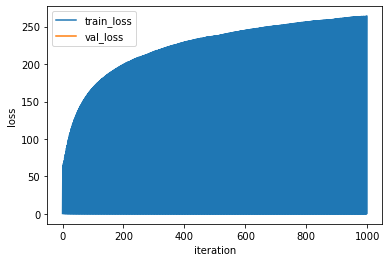

In [14]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# 그래프가 왜이러지?

In [15]:
# batch_size를 늘렸을 때
minibatch_net_128 = MinibatchNetwork(l2 = 0.01, batch_size=128) # 미니 배치의 크기가 128이고 L2 규제를 적용한 모델 생성
minibatch_net_128.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val, epochs = 500) # 훈련
minibatch_net_128.score(x_val_scaled, y_val) # 검증 세트로 성능 검증

0.978021978021978

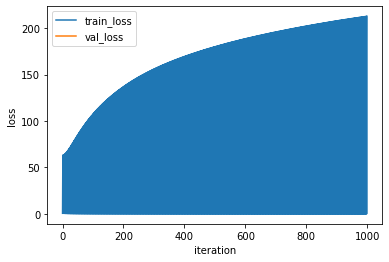

In [16]:
plt.plot(minibatch_net_128.losses)
plt.plot(minibatch_net_128.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

# 더 가파르긴 한데...왜이러지?

# 성능 측정 & 그래프 분석